## Iterative Cleaning of the Training and Test Data

In [5]:
#imports
import pandas as pd
import numpy as np
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [129]:
#load the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## DataFrame Cleaner
Certain functions will need to be done to every DataFrame. This function will help streamline that process.

In [130]:
def df_cleaner(df):
    '''
    Returns a cleaned version of the DataFrame passed.
    Columns Checked: overall_qual, gr_liv_area, year_built, year_remod/add
    Columns Cleaned: garage_area, total_bsmt_sf, bsmt_full_bath, full_bath, bsmt_half_bath, half_bath
    '''
    #rename columns pythonically
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    
    ##numeric columns
    #check columns that can't be 0 or null for null values
    for col in ['overall_qual', 'gr_liv_area', 'year_built', 'year_remod/add']:
        if df[col].isna().sum():
            print(f"{col.title()} has null values")
        
    #check for values outside the appropriate range
    if set(df['overall_qual'].unique()) - set(range(1,11)):
        print(f"Overall_qual has outlier {set(df['overall_qual'].unique()) - set(range(1,11))}")
    
    #replace potential NaNs in appropriate numeric columns with 0
    for col in ['garage_area', 'total_bsmt_sf', 'bsmt_full_bath', 'full_bath', 'bsmt_half_bath', 'half_bath']:
        df[col] = df[col].replace(np.nan, 0)
    
    ##categorical columns
    #make privacy fence column - GdPrv
    
    #lot config
    
    #paved drive??
    
    #Functional?
    
    #condition?
    
    #neighborhood?
    
    
    return df

In [131]:
train = df_cleaner(train)
test = df_cleaner(test)

In [132]:
#save cleaned data to new csvs
'''train.to_csv('../data/cleaned_train', index=False)
test.to_csv('../data/cleaned_test', index=False)'''

## Explore the Data
Because there are so many variables here, first I will explore some preliminary variables of interest and then choose some to clean.

<AxesSubplot:>

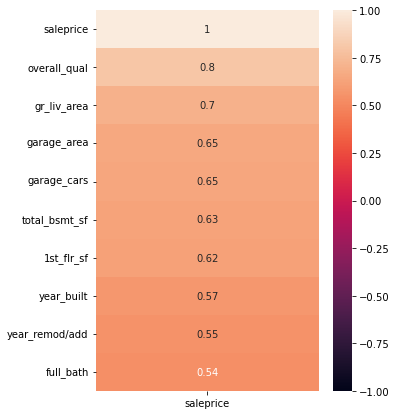

In [32]:
plt.figure(figsize=(5,7))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(10), annot=True, vmin=-1, vmax=1)

In [103]:
test.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [104]:
train['sale_type'].unique()

array(['WD ', 'New', 'COD', 'ConLD', 'Con', 'CWD', 'Oth', 'ConLI',
       'ConLw'], dtype=object)

In [83]:
train[train.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(10).index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   saleprice       2051 non-null   int64  
 1   overall_qual    2051 non-null   int64  
 2   gr_liv_area     2051 non-null   int64  
 3   garage_area     2051 non-null   float64
 4   garage_cars     2051 non-null   float64
 5   total_bsmt_sf   2051 non-null   float64
 6   1st_flr_sf      2051 non-null   int64  
 7   year_built      2051 non-null   int64  
 8   year_remod/add  2051 non-null   int64  
 9   full_bath       2051 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 160.4 KB


In [108]:
test.isna().sum().sum()

4171

In [106]:
train[train['gr_liv_area'] > 4000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


In [81]:
#look for suspicious min and max values
for col in train.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(10).index:
    print(f"{col.title()} min/Max: {train[col].min()} / {train[col].max()}")
    
    

Saleprice min/Max: 12789 / 611657
Overall_Qual min/Max: 1 / 10
Gr_Liv_Area min/Max: 334 / 5642
Garage_Area min/Max: 0.0 / 1418.0
Garage_Cars min/Max: 0.0 / 5.0
Total_Bsmt_Sf min/Max: 0.0 / 6110.0
1St_Flr_Sf min/Max: 334 / 5095
Year_Built min/Max: 1872 / 2010
Year_Remod/Add min/Max: 1950 / 2010
Full_Bath min/Max: 0 / 4


In [50]:
train.isna().sum().sort_values(ascending=False).iloc[:26]

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
dtype: int64

In [88]:
train.loc[1280]

id                   1743
pid             528228275
ms_subclass           120
ms_zoning              RL
lot_frontage         53.0
                  ...    
misc_val                0
mo_sold                 2
yr_sold              2007
sale_type             New
saleprice          194201
Name: 1280, Length: 81, dtype: object

<AxesSubplot:>

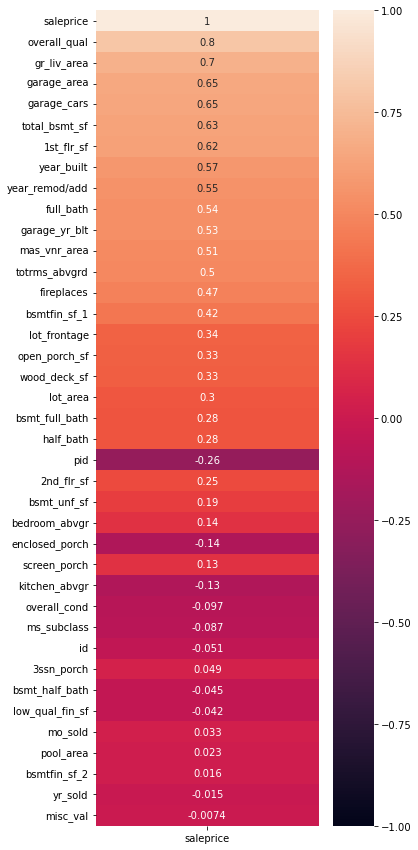

In [92]:
plt.figure(figsize=(5,15))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False), annot=True, vmin=-1, vmax=1)

In [40]:
train['gr_liv_area'].min(), train['gr_liv_area'].max()

(334, 5642)

In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [112]:
train[train['total_bsmt_sf'] > 5000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


In [65]:
train['total_bsmt_sf'].min(), train['total_bsmt_sf'].max()

(0.0, 6110.0)

In [70]:
train[train['total_bsmt_sf'] == 0].loc[:,[x for x in train.columns if 'bsmt' in x]]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
12,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
93,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
114,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
146,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
183,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
240,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
249,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
256,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
390,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
437,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [63]:
test.isna().sum().sort_values(ascending=False).iloc[:26]

Pool QC           874
Misc Feature      837
Alley             820
Fence             706
Fireplace Qu      422
Lot Frontage      160
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Garage Type        44
BsmtFin Type 1     25
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 2     25
Electrical          1
Mas Vnr Type        1
Mas Vnr Area        1
Kitchen AbvGr       0
TotRms AbvGrd       0
Bedroom AbvGr       0
Half Bath           0
Full Bath           0
Bsmt Half Bath      0
Bsmt Full Bath      0
dtype: int64

In [61]:
train.dropna(axis=0, thresh=train.shape[1] - 5).shape, train.shape

((1798, 81), (2051, 81))

<AxesSubplot:>

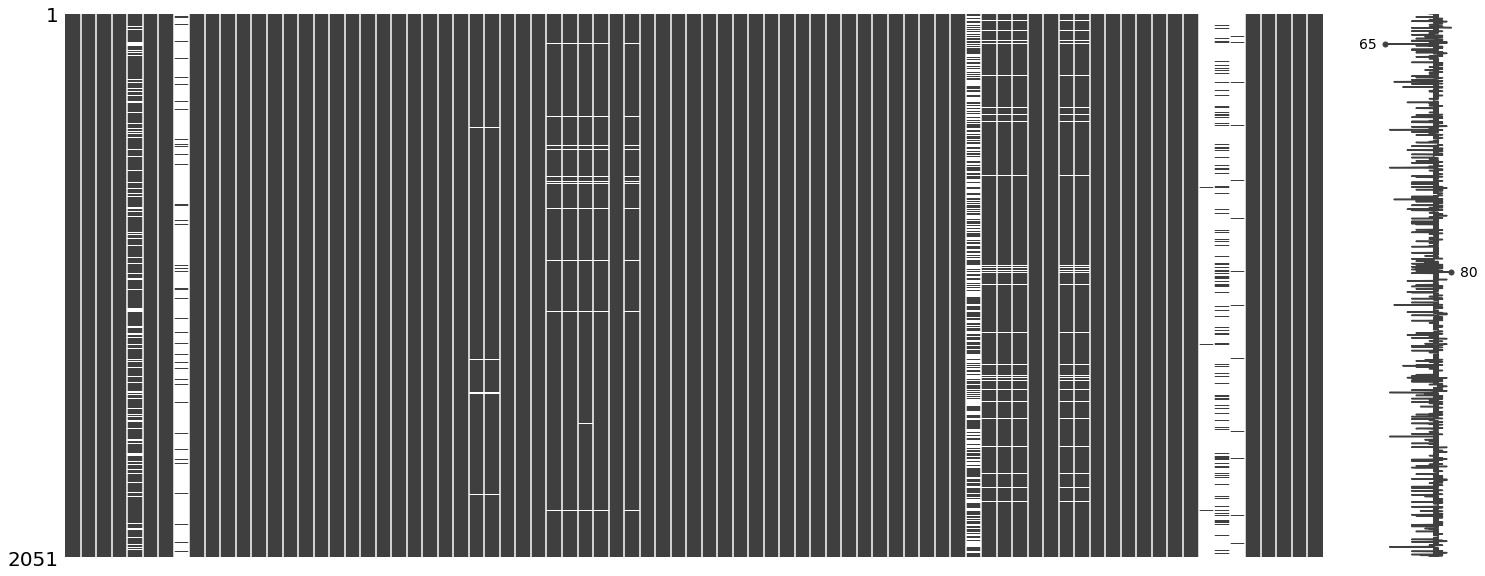

In [133]:
msn.matrix(train)

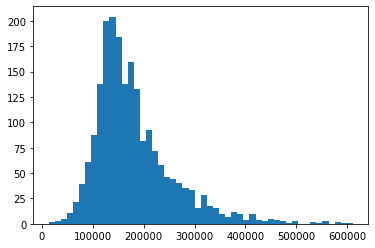

In [135]:
plt.hist(train['saleprice'], bins=50);

In [ ]:
sns.pairplot(train, x_vars=['garage_area', 'total_bsmt_sf', 'bsmt_full_bath', 'full_bath', 'bsmt_half_bath', 'half_bath','overall_qual', 'gr_liv_area', 'year_built', 'year_remod/add', 'lot_frontage', 'lot_area'], y_vars=['saleprice'])
